In [1]:
"""
Code function:
1)This code classifies a natural product from its SMILES strings according to their Pathway, SuperClass and Class.
    Uses the NPClassifier free-access application reported in  https://pubs.acs.org/doi/10.1021/acs.jnatprod.1c00399 .
    It uses the API of NPClassifier, nonetheless, the SMILES can be individually submitted in the following web site: https://npclassifier.ucsd.edu/ .
2)After classifying all the compounds are determined the individual counts of all the obtained labels in Pathway, SuperClass and Class and this 
information is exported into an excel file.
3)Pie charts are constructed to visualize the previous information.

Requirements/Notes: 
1) The column containing the IDs must have a header labeled 'ID'.
2) The column containing the SMILES must have a header labeled 'Smiles'.
3) Modify in the script the name of the input file.
4) The file xxx_counts_complete.xlsx contain the individual counts of all the compounds.
   The file xxx_counts_modified.xlsx contain the counts of just the first 9 labels with more compounds and the remaining are grouped as 'Others'.
In the blocks of code where the counts are set, modify the number in the following lines of class and superclass 'top_n_class = 9' if it is
intended to keep a different number of top entries and group the remaining as 'Others' in the file xxx_counts_modified.xlsx. 
5)The pie charts uses as input xxx_counts_complete.xlsx, nonetheless, can be modified the number of the following line of code on every chart to
keep a diferent number of top entries and group the remaining as 'Others' : 'top_n = 10'.
"""

import pandas as pd
import requests
import concurrent.futures
from json import JSONDecodeError
import time

# ============================
# CONFIGURATION
# ============================
MAX_WORKERS = 30       # <<< Modify: number of simultaneous compounds processed

# ============================
# LOAD INPUT FILE
# ============================
dfi = pd.read_excel("input_file.xlsx")  # Input file
dfi['Index'] = dfi.reset_index().index  

smiles = dfi.Smiles
ids = dfi.ID
indexes = dfi.Index

# ============================
# STORAGE LISTS
# ============================
results = {
    "ID": [],
    "Smiles": [],
    "Pathway": [],
    "SuperClass": [],
    "Class": [],
    "Error_Type": [],
}

# ============================
# FUNCTION TO CLASSIFY SMILES
# ============================
def classify_smiles(entry):
    smi, compound_id, idx = entry
    url = "https://npclassifier.ucsd.edu/classify?smiles=" + smi

    try:
        r = requests.get(url, timeout=None)
        data = r.json()

        pathway = str(data.get("pathway_results", [])).replace("[","").replace("]","").replace("'","")
        superclass = str(data.get("superclass_results", [])).replace("[","").replace("]","").replace("'","")
        classres = str(data.get("class_results", [])).replace("[","").replace("]","").replace("'","")

        return (compound_id, smi, pathway or "not_classified", superclass or "not_classified", classres or "not_classified", "")
    
    except JSONDecodeError:
        return (compound_id, smi, "try_again_error", "try_again_error", "try_again_error", "JSONDecodeError")
    except requests.exceptions.Timeout:
        return (compound_id, smi, "time_error", "time_error", "time_error", "TimeoutError")
    except requests.exceptions.RequestException:
        return (compound_id, smi, "time_error", "time_error", "time_error", "OtherError")

# ============================
# PARALLEL PROCESSING WITH CUSTOM PROGRESS
# ============================
entries = list(zip(smiles, ids, indexes))
total = len(entries)
start_time = time.time()

print(f"\n🔎 Compounds pending classification: {total}\n")

try:
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(classify_smiles, entry): entry for entry in entries}

        processed = 0
        last_id = None

        for future in concurrent.futures.as_completed(futures):
            compound_id, smi, pathway, superclass, classres, error = future.result()

            # Store results
            results["ID"].append(compound_id)
            results["Smiles"].append(smi)
            results["Pathway"].append(pathway)
            results["SuperClass"].append(superclass)
            results["Class"].append(classres)
            results["Error_Type"].append(error)

            # Update counters
            processed += 1
            last_id = compound_id
            remaining = total - processed

            # Calculate percentage
            percent = (processed / total) * 100
            bar_length = 20
            filled_length = int(bar_length * processed // total)
            bar = "#" * filled_length + "-" * (bar_length - filled_length)

            # Print status line with custom style
            print(
                f"\r[{bar}] {processed}/{total} ({percent:.1f}%) "
                f"| Remaining: {remaining} "
                f"| Last successful ID: {last_id}",
                end="", flush=True
            )

    # ============================
    # SAVE RESULTS TO EXCEL
    # ============================
    df = pd.DataFrame(results)
    df.to_excel("results.xlsx", index=False)
    print(f"\n\n✅ Classification completed. Results saved in results.xlsx")

except KeyboardInterrupt:
    # Handle manual interruption
    df = pd.DataFrame(results)
    df.to_excel("results_partial.xlsx", index=False)
    print(f"\n\n🛑 Interrupted by user. Saving progress up to ID: {last_id}...")
    print(f"💾 Progress saved in results_partial.xlsx")



🔎 Compounds pending classification: 1332

[####################] 1332/1332 (100.0%) | Remaining: 0 | Last successful ID: LANaPDB149078

✅ Classification completed. Results saved in results.xlsx


In [2]:
# Separation into multiple columns in cases where there is more than one Pathway, SuperClass, or Class
# Code inspired by: https://practicaldatascience.co.uk/data-science/how-to-split-a-pandas-column-string-or-list-into-separate-columns#:~:text=using%20the%20str.-,split()%20function.,a%20Python%20list%20of%20values.

import pandas as pd
import numpy as np

df = pd.read_excel("results.xlsx")


df['Pathway_list'] = df['Pathway'].str.split(',') # Convert the 'Pathway' column to a list, specifying that the separator is a comma
df_pathway = pd.DataFrame(df['Pathway_list'].tolist()).fillna('').add_prefix('Pathway_')
df = pd.concat([df, df_pathway], axis=1)

# Convert the 'SuperClass' column to a list
df['SuperClass_list'] = df['SuperClass'].str.split(',')
df_superclass = pd.DataFrame(df['SuperClass_list'].tolist()).fillna('').add_prefix('SuperClass_')
df = pd.concat([df, df_superclass], axis=1)

# Prevent Carotenoids (C40, β-β) and C45 from being split by the comma inside their name
df['Class'] = df['Class'].str.replace('C40,', 'C40')
df['Class'] = df['Class'].str.replace('C45,', 'C40')
# Prevent Indole diketopiperazine alkaloids (L-Trp, L-Ala) from being split by the comma inside their name
df['Class'] = df['Class'].str.replace('L-Trp,', 'L-Trp')
# Prevent Apocarotenoids (C30, Ψ-Ψ) from being split by the comma inside their name
df['Class'] = df['Class'].str.replace('C30,', 'C30')

# Convert the 'Class' column to a list
df['Class_list'] = df['Class'].str.split(',')
df_class = pd.DataFrame(df['Class_list'].tolist()).fillna('').add_prefix('Class_')
df = pd.concat([df, df_class], axis=1)

# Save the final DataFrame to a new Excel file
df.to_excel("results_separated.xlsx")


In [3]:
import pandas as pd
import numpy as np

# Concatenation into a single column and removal of unwanted characters

# Initialize empty DataFrames
dfp = pd.DataFrame()
dfsc = pd.DataFrame()
dfc = pd.DataFrame()

# Concatenate Pathway columns
pathway_cols = df.filter(regex='Pathway_')  # Keep only the columns matching the pattern 'Pathway_'
pathway_cols = pathway_cols.iloc[:, 1:]     # Remove the first column, which is "Pathway_list"
dfp['Pathway'] = pd.concat([df[col] for col in pathway_cols.columns], axis=0)

# Concatenate SuperClass columns
superclass_cols = df.filter(regex='SuperClass_')
superclass_cols = superclass_cols.iloc[:, 1:]
dfsc['SuperClass'] = pd.concat([df[col] for col in superclass_cols.columns], axis=0)

# Concatenate Class columns
class_cols = df.filter(regex='Class_')
class_cols = class_cols.iloc[:, 1:]
dfc['Class'] = pd.concat([df[col] for col in class_cols.columns], axis=0)

# Removal of unwanted characters
unwanted_values = ['try_again_error', 'not_classified']

for val in unwanted_values:
    dfp['Pathway'] = dfp['Pathway'].str.replace(val, '', regex=False)
    dfsc['SuperClass'] = dfsc['SuperClass'].str.replace(val, '', regex=False)
    dfc['Class'] = dfc['Class'].str.replace(val, '', regex=False)

# Remove rows with empty values
dfp.replace('', np.nan, inplace=True)
dfp.dropna(inplace=True)

dfsc.replace('', np.nan, inplace=True)
dfsc.dropna(inplace=True)

dfc.replace('', np.nan, inplace=True)
dfc.dropna(inplace=True)

# Reset the indexes
dfp.reset_index(drop=True, inplace=True)
dfsc.reset_index(drop=True, inplace=True)
dfc.reset_index(drop=True, inplace=True)

# Remove leading and trailing whitespace from each string (using .map to avoid FutureWarning)
dfp['Pathway'] = dfp['Pathway'].map(lambda x: x.strip() if isinstance(x, str) else x)
dfsc['SuperClass'] = dfsc['SuperClass'].map(lambda x: x.strip() if isinstance(x, str) else x)
dfc['Class'] = dfc['Class'].map(lambda x: x.strip() if isinstance(x, str) else x)

# Optional: save results in Excel
# dfp.to_excel("dfp.xlsx", index=False)
# dfsc.to_excel("dfsc.xlsx", index=False)
# dfc.to_excel("dfc.xlsx", index=False)


In [4]:
# -----------------------------
# Calculate counts for Pathway
# -----------------------------
dfp['Pathway'] = dfp['Pathway'].str.strip()  # Remove leading/trailing spaces
dfcc_pathway = dfp['Pathway'].value_counts().reset_index()
dfcc_pathway.columns = ['Pathway', 'counts']  # Rename columns
dfcc_pathway = dfcc_pathway.sort_values('counts', ascending=False)
dfcc_pathway.to_excel('Pathway_counts.xlsx', index=False)


# -----------------------------
# SUPERCLASS COUNTS
# -----------------------------
top_n_super = 9  # <-- Change this value to modify the number of top SuperClass entries

# Calculate counts for SuperClass
SuperClass_counts = dfsc['SuperClass'].str.strip()  # remove whitespace
dfcc_super = SuperClass_counts.value_counts().rename_axis('SuperClass').reset_index(name='counts')

# Sort from highest to lowest
dfcc_super = dfcc_super.sort_values('counts', ascending=False)

# Save the complete counts (without grouping Others)
dfcc_super.to_excel('SuperClass_counts_complete.xlsx', index=False)

# Keep only the top_n_super and group the rest as 'Others' if necessary
if len(dfcc_super) > top_n_super:
    top_n = dfcc_super.iloc[:top_n_super]
    others_count = dfcc_super.iloc[top_n_super:]['counts'].sum()
    others_row = pd.DataFrame({'SuperClass': ['Others'], 'counts': [others_count]})
    dfcc_super = pd.concat([top_n, others_row], ignore_index=True)

# Save the modified counts (with Others grouped)
dfcc_super.to_excel('SuperClass_counts_modified.xlsx', index=False)


# -----------------------------
# CLASS COUNTS
# -----------------------------
top_n_class = 9  # <-- Change this value to modify the number of top Class entries

# Calculate counts for Class
Class_counts = dfc['Class'].str.strip()  # remove whitespace
dfcc_class = Class_counts.value_counts().rename_axis('Class').reset_index(name='counts')

# Sort from highest to lowest
dfcc_class = dfcc_class.sort_values('counts', ascending=False)

# Save the complete counts (without grouping Others)
dfcc_class.to_excel('Class_counts_complete.xlsx', index=False)

# Keep only the top_n_class and group the rest as 'Others' if necessary
if len(dfcc_class) > top_n_class:
    top_n = dfcc_class.iloc[:top_n_class]
    others_count = dfcc_class.iloc[top_n_class:]['counts'].sum()
    others_row = pd.DataFrame({'Class': ['Others'], 'counts': [others_count]})
    dfcc_class = pd.concat([top_n, others_row], ignore_index=True)

# Save the modified counts (with Others grouped)
dfcc_class.to_excel('Class_counts_modified.xlsx', index=False)


In [5]:
import plotly.express as px
import plotly
import kaleido
import os
import pandas as pd

# Create folder for images if it doesn't exist
if not os.path.exists("images"):
    os.mkdir("images")

# Read data from Excel
dfi = pd.read_excel("Pathway_counts.xlsx")

# ============================
# Remove unwanted error labels
# ============================
exclude_labels = ["try_again_error", "time_error", "TimeoutError", "OtherError", "not_classified"]
dfi = dfi[~dfi["Pathway"].isin(exclude_labels)]

# ============================
# Parameter: number of top elements to keep
# ============================
top_n = 10   # <<< Change this number to keep more/fewer elements before grouping the rest as "Others"

# Sort values by counts (descending)
dfi_sorted = dfi.sort_values(by="counts", ascending=False).reset_index(drop=True)

# Keep top_n and group the rest as "Others"
top_data = dfi_sorted.iloc[:top_n].copy()
others_sum = dfi_sorted.iloc[top_n:]["counts"].sum()

if others_sum > 0:
    top_data = pd.concat([
        top_data,
        pd.DataFrame({"Pathway": ["Others"], "counts": [others_sum]})
    ])

# ============================
# Create pie chart
# ============================
fig = px.pie(
    top_data,
    names="Pathway",
    values="counts",
    title="Pathway"
)

# ============================
# Percentages inside the chart
# ============================
fig.update_traces(
    textinfo="percent",     # <<< Controls what text appears inside slices ("percent", "label", "value", etc.)
    textfont_size=28        # <<< Change percentage font size here
)

# ============================
# Title, labels, legend styling
# ============================
fig.update_layout(
    title=dict(
        text="Pathway",
        x=0.2,                # <<< Move title along X-axis (0 = left, 1 = right)
        y=0.9,                # <<< Move title along Y-axis (0 = bottom, 1 = top)
        xanchor="right",      # <<< Horizontal anchor point for title
        yanchor="top",        # <<< Vertical anchor point for title
        font=dict(size=46)    # <<< Change title font size here
    ),
    font_size=20,             # <<< Change default label font size (applies to tick labels, slice labels, etc.)
    legend_title_text="", 
    legend=dict(
        orientation="v",
        yanchor="middle",     
        y=0.5,                # <<< Move legend along Y-axis
        xanchor="left",       
        x=1.1,                  # <<< Move legend box along X-axis (controls its horizontal position)
        font=dict(size=34)    # <<< Change legend labels font size here
    ),
    width=1400,
    height=800,
    margin=dict(t=150, b=100, l=80, r=300)  
)

# Show interactive chart
fig.show()

# ============================
# Export for publication
# ============================
fig.write_image(
    "images/1_pathway.png",   # <<< Output filename
    format="png",
    width=1250,
    height=800,
    scale=1   
)


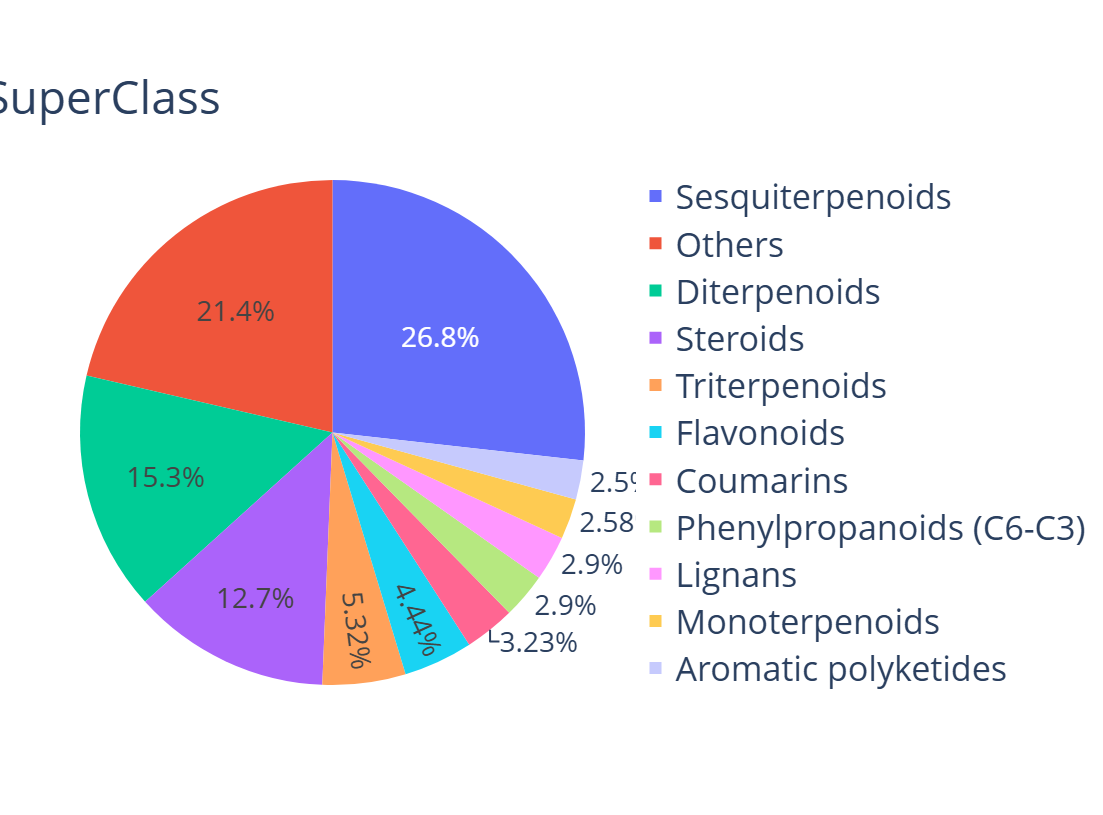

In [6]:
import plotly.express as px
import plotly
import kaleido
import os
import pandas as pd

# Create folder for images if it doesn't exist
if not os.path.exists("images"):
    os.mkdir("images")

# Read data from Excel
dfi = pd.read_excel("SuperClass_counts_complete.xlsx")  # <<< Change file name if needed

# ============================
# Remove unwanted error labels
# ============================
exclude_labels = ["try_again_error", "time_error", "TimeoutError", "OtherError", "not_classified"]
dfi = dfi[~dfi["SuperClass"].isin(exclude_labels)]

# ============================
# Parameter: number of top elements to keep
# ============================
top_n = 10   # <<< Change this number to keep more/fewer elements

# Sort values by counts (descending)
dfi_sorted = dfi.sort_values(by="counts", ascending=False).reset_index(drop=True)

# Keep top_n and group the rest as "Others"
top_data = dfi_sorted.iloc[:top_n].copy()
others_sum = dfi_sorted.iloc[top_n:]["counts"].sum()

if others_sum > 0:
    top_data = pd.concat([
        top_data,
        pd.DataFrame({"SuperClass": ["Others"], "counts": [others_sum]})
    ])

# ============================
# Create pie chart
# ============================
fig = px.pie(
    top_data,
    names="SuperClass",   # <<< Use "SuperClass" column
    values="counts",
    title="SuperClass"
)

# --- Percentages inside the chart ---
fig.update_traces(
    textinfo="percent",
    textfont_size=28   # <<< Change percentage font size here
)

# --- Title, legend, margins ---
fig.update_layout(
    title=dict(
        text="SuperClass",
        x=0.2,     # <<< Move title along X-axis (0 = left, 1 = right)
        y=0.9,     # <<< Move title along Y-axis (0 = bottom, 1 = top)
        xanchor="right",  # Horizontal anchor of the title
        yanchor="top",    # Vertical anchor of the title
        font=dict(size=46)  # <<< Change title font size here
    ),
    font_size=20,  # <<< Change default text size (applies to labels, ticks, etc.)
    legend_title_text="", 
    legend=dict(
        orientation="v",
        yanchor="middle",  
        y=0.5,              # <<< Move legend along Y-axis
        xanchor="left",     
        x=1.1,                # <<< Move legend along X-axis (controls legend box position)
        font=dict(size=34)  # <<< Change legend labels font size here
    ),
    width=1400,
    height=800,
    margin=dict(t=150, b=100, l=80, r=300)  
)

# Show interactive chart
fig.show()

# ============================
# Export for publication
# ============================
fig.write_image(
    "images/2_superclass.png",   # <<< Output filename
    format="png",
    width=1250,
    height=800,
    scale=1   
)


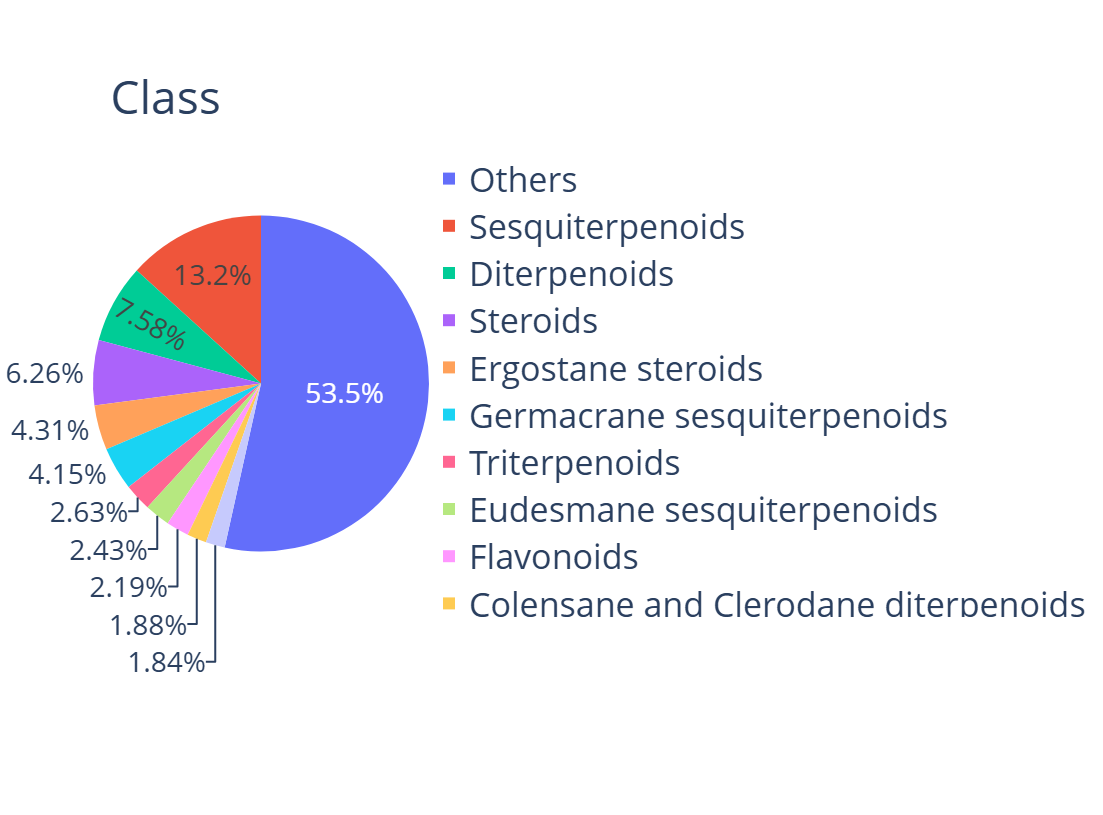

C:\Users\alexg\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotly\io\_kaleido.py:510: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




In [9]:
import plotly.express as px
import plotly
import kaleido
import os
import pandas as pd

# Create folder for images if it doesn't exist
if not os.path.exists("images"):
    os.mkdir("images")

# Read data from Excel
dfi = pd.read_excel("Class_counts_complete.xlsx")  # <<< Change file name if needed

# ============================
# Remove unwanted error labels
# ============================
exclude_labels = ["try_again_error", "time_error", "TimeoutError", "OtherError", "not_classified"]
dfi = dfi[~dfi["Class"].isin(exclude_labels)]

# ============================
# Parameter: number of top elements to keep
# ============================
top_n = 10   # <<< Change this number to keep more/fewer elements before grouping the rest as "Others"

# Sort values by counts (descending)
dfi_sorted = dfi.sort_values(by="counts", ascending=False).reset_index(drop=True)

# Keep top_n and group the rest as "Others"
top_data = dfi_sorted.iloc[:top_n].copy()
others_sum = dfi_sorted.iloc[top_n:]["counts"].sum()

if others_sum > 0:
    top_data = pd.concat([
        top_data,
        pd.DataFrame({"Class": ["Others"], "counts": [others_sum]})
    ])

# ============================
# Create pie chart
# ============================
fig = px.pie(
    top_data,
    names="Class",    # <<< Use "Class" column
    values="counts",
    title="Class"
)

# ============================
# Percentages inside the chart
# ============================
fig.update_traces(
    textinfo="percent",     # <<< Controls what text appears inside slices ("percent", "label", "value", etc.)
    textfont_size=28        # <<< Change percentage font size here
)

# ============================
# Title, labels, legend styling
# ============================
fig.update_layout(
    title=dict(
        text="Class",
        x=0.2,                # <<< Move title along X-axis (0 = left, 1 = right)
        y=0.9,                # <<< Move title along Y-axis (0 = bottom, 1 = top)
        xanchor="right",      # <<< Horizontal anchor point for title
        yanchor="top",        # <<< Vertical anchor point for title
        font=dict(size=46)    # <<< Change title font size here
    ),
    font_size=20,             # <<< Change default label font size (applies to tick labels, slice labels, etc.)
    legend_title_text="", 
    legend=dict(
        orientation="v",
        yanchor="middle",     
        y=0.5,                # <<< Move legend along Y-axis
        xanchor="left",       
        x=1,                  # <<< Move legend box along X-axis (controls its horizontal position)
        font=dict(size=34)    # <<< Change legend labels font size here
    ),
    width=1400,
    height=800,
    margin=dict(t=150, b=100, l=80, r=300)  
)

# Show interactive chart
fig.show()

# ============================
# Export for publication
# ============================
fig.write_image(
    "images/3_class.png",   # <<< Output filename
    format="png",
    width=1250,
    height=800,
    scale=1   
)
